[IPython Notebook](pblum.ipynb) |  [Python Script](pblum.py)

Passband Luminosity
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](building_a_system.html) for more details.

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

/usr/local/lib/python2.7/dist-packages/astropy/units/quantity.py:782: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return super(Quantity, self).__eq__(other)


And we'll add a single light curve dataset so that we can see how passband luminosities affect the resulting synthetic light curve model.

In [3]:
b.add_dataset('lc', times=np.linspace(0,3,101), dataset='lc01')

<ParameterSet: 12 parameters | kinds: lc, lc_dep>

Lastly, just to make things a bit easier, we'll turn off limb-darkening.

In [4]:
b.set_value_all('ld_func', 'logarithmic')
b.set_value_all('ld_coeffs', [0,0])

Relevant Parameters
-----------------------



The 'pblum_ref' parameter exists for each component-dataset pair and it determines how the intensities for that star in that passband should be scaled, i.e. by the pblum provided by that component ('self') or coupled to the pblum provided by another component.

By default the passband luminosities are *coupled* (see below for explanations of coupled vs decoupled), with the passband luminosity being defined by the primary component in the system.

In [5]:
print b['pblum_ref']

ParameterSet: 2 parameters
  pblum_ref@primary@lc01@dataset: self
  pblum_ref@secondary@lc01@da...: primary


In [6]:
print b['pblum_ref@primary']

Parameter: pblum_ref@primary@lc01@dataset
                       Qualifier: pblum_ref
                     Description: Whether to use this components pblum or to couple to that from another component in the system
                           Value: self
                         Choices: self, primary, secondary



The 'pblum' parameter is only relevant for each component-dataset pair in which pbscale==pblum.  This component will then have its intensities scaled such that they match the value provided by pblum.  In general, a pblum of 4pi will result in an out-of-eclipse flux of ~1.

In [7]:
print b['pblum']

Parameter: pblum@primary@lc01@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 12.5663706144 W
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: pblum_ref:self



**NOTE:** other parameters also affect flux-levels, including [limb darkening](limb_darkening) and [distance](distance)

Coupled Luminosities
------------------------

Passband luminosities are considered coupled when a single pblum value is provided, while the passband luminosity of the other component(s) is scaled by the same factor.  To accomplish this, ONE pblum_ref in the system must be set as 'self' and ALL OTHER pbscales must refer to that component. This is the default case, set explicitly by:

In [8]:
b['pblum_ref@primary'] = 'self'

In [9]:
b['pblum_ref@secondary'] = 'primary'

Now note that only a single pblum parameter is visible.

In [10]:
print b['pblum']

Parameter: pblum@primary@lc01@dataset
                       Qualifier: pblum
                     Description: Passband luminosity (defined at t0)
                           Value: 12.5663706144 W
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: pblum_ref:self



Let's see how changing the value of pblum affects the computed light curve.  By default, pblum is set to be 4 pi, giving a total flux for the primary star of ~1.

Since the secondary star in the default binary is identical to the primary star, we'd expect an out-of-eclipse flux of the binary to be ~2.

In [11]:
b.run_compute()

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

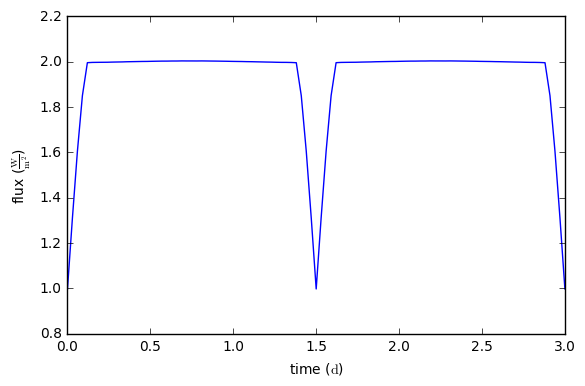

In [12]:
axs, artists = b.plot(dataset='lc01')

If we now set pblum to be only 2 pi, we should expect the entire light curve to be scaled in half.

In [13]:
b['pblum@primary'] = 2 * np.pi

In [14]:
b.run_compute()

Wed, 21 Sep 2016 18:01 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

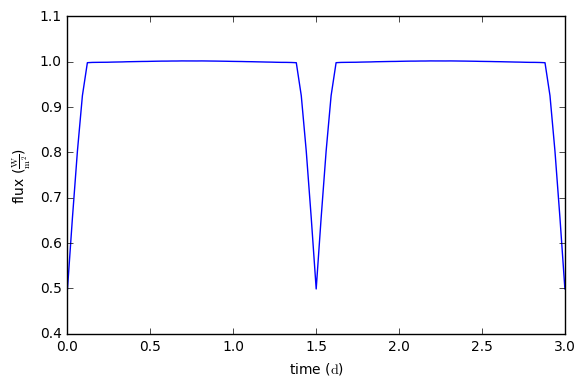

In [15]:
axs, artist = b.plot()

And if we introduce a significant temperature ratio - the resulting light curve changes to the new sum of fluxes, where the primary star dominates since the secondary star flux is reduced by a factor of 16, so we expect a total out-of-eclipse flux of ~0.5 + ~0.5/16 = ~0.53.

In [16]:
print b['teff']

ParameterSet: 2 parameters
          teff@primary@component: 10000.0 K
        teff@secondary@component: 10000.0 K


In [17]:
b['teff@secondary'] = 5000.

Wed, 21 Sep 2016 18:03 PARAMETERS   WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


In [18]:
b.run_compute()

Wed, 21 Sep 2016 18:03 BUNDLE       WARNING overwriting model: latest
Wed, 21 Sep 2016 18:03 BUNDLE       WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

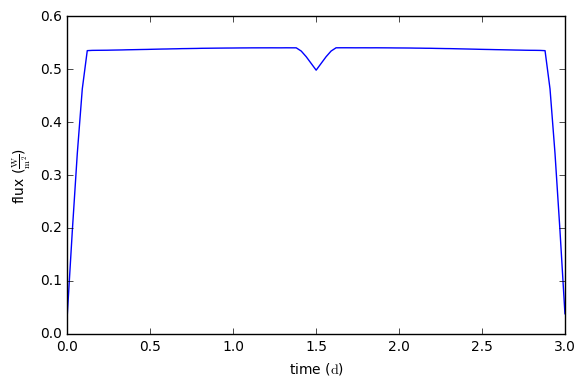

In [19]:
axs, artists = b.plot()

Let us undo our changes before we look at decoupled luminosities.

In [20]:
b.set_value_all('teff', 10000)
b.set_value_all('pblum', 4*np.pi)

Wed, 21 Sep 2016 18:04 PARAMETERS   WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


Decoupled Luminosities
----------------------------

The luminosities are decoupled when pblums are provided for the individual components.  To accomplish this, all 'pblum_ref' parameters should be set to 'self'.

In [21]:
b.set_value_all('pblum_ref', 'self')

Now we see that both pblums are available and can have different values.

In [22]:
print b['pblum']

ParameterSet: 2 parameters
      pblum@primary@lc01@dataset: 12.5663706144 W
    pblum@secondary@lc01@dataset: 12.5663706144 W


If we set these to 4pi, then we'd expect each star to contribute 1.0 in flux units, meaning the baseline of the light curve should be at approximately 2.0

In [23]:
b.set_value_all('pblum', 4*np.pi)

In [24]:
b.run_compute()

Wed, 21 Sep 2016 18:04 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

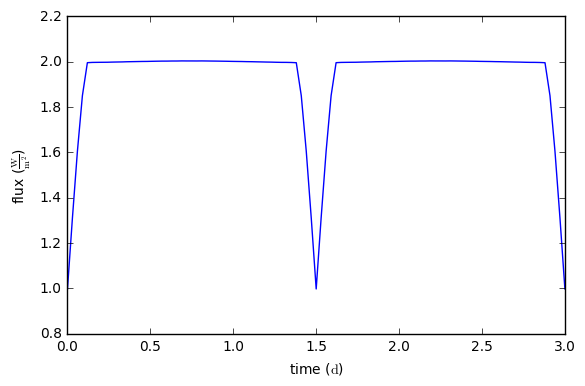

In [25]:
axs, artists = b.plot()

Now let's make a significant temperature-ratio by making a very cool secondary star.  Since the luminosities are decoupled - this temperature change won't affect the resulting light curve very much (compare this to the case above with coupled luminosities).  What is happening here is that even though the secondary star is *cooler*, its luminosity is being rescaled to the same value as the primary star, so the eclipse depth doesn't change (you would see a similar lack-of-effect if you changed the radii).

In [26]:
print b['teff']

ParameterSet: 2 parameters
          teff@primary@component: 10000.0 K
        teff@secondary@component: 10000.0 K


In [27]:
b['teff@secondary'] = 5000

Wed, 21 Sep 2016 18:05 PARAMETERS   WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


In [28]:
b.run_compute()

Wed, 21 Sep 2016 18:05 BUNDLE       WARNING overwriting model: latest
Wed, 21 Sep 2016 18:05 BUNDLE       WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

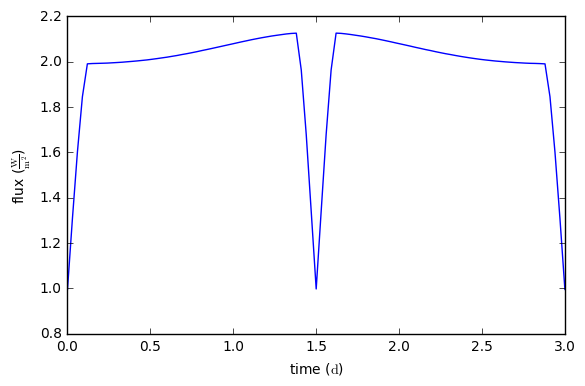

In [29]:
axs, artists = b.plot()

In most cases you will *not want* decoupled luminosities as they can easily break the self-consistency of your model.

Now we'll just undo our changes before we look at accessing model luminosities.

In [30]:
b.set_value_all('teff', 10000)
b.set_value_all('pblum', 4*np.pi)
b['pblum_ref@primary'] = 'self'
b['pblum_ref@secondary'] = 'primary'

Wed, 21 Sep 2016 18:06 PARAMETERS   WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


Accessing Model Luminosities
-----------------------------------

Luminosities of the individual stars in a system can be accessed through the mesh (either through creating a mesh dataset or by setting pbmesh=True during run_compute).  For stars that have pblum defined (as opposed to coupled to another star in the system), this value should be equivalent to pblum at t0 - and in simple circular cases will probably be equivalent at all times.

Let's create a mesh dataset at a few times and then access the synthetic luminosities.

In [31]:
b.add_dataset('mesh', times=np.linspace(0,1,5), dataset='mesh01')

<ParameterSet: 2 parameters | contexts: compute, dataset>

In [32]:
b.run_compute()

Wed, 21 Sep 2016 18:07 BUNDLE       WARNING overwriting model: latest


<ParameterSet: 364 parameters | kinds: mesh, lc>

Since the luminosities are passband-dependent, they are stored with the same dataset as the light curve (or RV), but with the mesh method, and are available at each of the times at which a mesh was stored.

In [33]:
print b.filter(qualifier='pblum', context='model').twigs

['0.0@pblum@primary@lc01@phoebe01@latest@mesh@model', '0.25@pblum@primary@lc01@phoebe01@latest@mesh@model', '0.5@pblum@primary@lc01@phoebe01@latest@mesh@model', '0.75@pblum@primary@lc01@phoebe01@latest@mesh@model', '1.0@pblum@primary@lc01@phoebe01@latest@mesh@model', '0.0@pblum@secondary@lc01@phoebe01@latest@mesh@model', '0.25@pblum@secondary@lc01@phoebe01@latest@mesh@model', '0.5@pblum@secondary@lc01@phoebe01@latest@mesh@model', '0.75@pblum@secondary@lc01@phoebe01@latest@mesh@model', '1.0@pblum@secondary@lc01@phoebe01@latest@mesh@model']


Now let's compare the value of the *synthetic* luminosities to those of the *input* pblum

In [34]:
t0 = b.get_value('t0@system')

In [35]:
print b.get_value(qualifier='pblum', time=t0, component='primary', kind='mesh', context='model')

12.5812463519


In [36]:
print b.get_value('pblum@primary@dataset')

12.5663706144


In this case, since our two stars are identical, the *synthetic* luminosity of the secondary star should be the same as the primary (and the same as pblum@primary).

In [37]:
print b.get_value(qualifier='pblum', time=t0, component='primary', kind='mesh', context='model')

12.5812463519


In [38]:
print b.get_value(qualifier='pblum', time=t0, component='secondary', kind='mesh', context='model')

12.5812463519


However, if we change the temperature of the secondary star again, since the pblums are coupled, we'd expect the *synthetic* luminosity of the primary to remain fixed but the secondary to decrease.

In [39]:
b['teff@secondary@component'] = 5000

Wed, 21 Sep 2016 18:08 PARAMETERS   WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


In [40]:
b.run_compute()

Wed, 21 Sep 2016 18:08 BUNDLE       WARNING overwriting model: latest
Wed, 21 Sep 2016 18:08 BUNDLE       WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


<ParameterSet: 364 parameters | kinds: mesh, lc>

In [41]:
print b.get_value(qualifier='pblum', time=t0, component='primary', kind='mesh', context='model')

12.5674442935


In [42]:
print b.get_value(qualifier='pblum', time=t0, component='secondary', kind='mesh', context='model')

0.984062194908


Now, we'll just undo our changes before continuing

In [43]:
b.set_value_all('teff@component', 10000)

Wed, 21 Sep 2016 18:09 PARAMETERS   WARNING Object probably has a convective atm (teff=5000K<6600K), for which gravb_bol=0.32 might be a better approx than gravb_bol=1.00


Role of Pblum
----------------------

Let's now look at the intensities in the mesh to see how they're being scaled under-the-hood.

In [44]:
areas = b.get_value(qualifier='areas', dataset='mesh01', time=t0, component='primary', unit='m^2')
abs_normal_intensities = b.get_value(qualifier='abs_normal_intensities', dataset='lc01', time=t0, component='primary')
normal_intensities = b.get_value(qualifier='normal_intensities', dataset='lc01', time=t0, component='primary')

'abs_normal_intensities' are the intensities per triangle in absolute units, i.e. W/m^3.

In [45]:
np.median(abs_normal_intensities)

/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

The values of 'normal_intensities', however, are significantly samller (in this case).  These are the intensities in relative units which will eventually be integrated to give us flux for a light curve.

In [46]:
np.median(normal_intensities)

6.5496969399165084e-19

'normal_intensities' are scaled from 'abs_normal_intensities' **so that** the comuted luminosity matches the prescribed luminosity (pblum).

Here we compute the luminosity by summing over each triangle's intensity in the normal direction, and multiply it by pi to account for blackbody intensity emitted in all directions in the solid angle, and by the area of that triangle.

In [47]:
pblum = b.get_value(qualifier='pblum', component='primary', context='dataset')
np.sum(normal_intensities * np.pi * areas)==pblum

False